## Created by <a href="https://github.com/yunsuxiaozi/">yunsuxiaozi</a> 2024/4/19

### 在<a href="https://www.kaggle.com/code/yunsuxiaozi/mnist-dataset-starter-notebook">MNIST dataset Starter Notebook</a>,我们实现了对MNIST数据集的分类,那个数据集特别简单,很容易就能够达到99%的准确率(我目前最高达到了99.4%的准确率,据说测试集有部分图像标签有错误,影响了最终的准确率).

### 在这个notebook中,我们将对Fashion-Mnist数据集进行分类,这个数据集的难度有点大,个人认为如果能够达到90%的准确率就已经比较厉害了(我尝试过很多次最好成绩也就0.932,而且在CNN里添加了很多模块,这里就不展示了。)


### 数据来源:<a href="https://www.kaggle.com/datasets/zalando-research/fashionmnist/data">Fashion MNIST</a>

### Fashion-Mnist的sota:<a href="https://paperswithcode.com/sota/image-classification-on-fashion-mnist?metric=Accuracy">State of the art</a>

### 在本文当中,我将带大家搭建一个简单的CNN模型,来对这个数据集进行分类.(这里只是实现代码逻辑,如果想达到更好的效果可以尝试网络模型的加深和迭代次数的增加)

#### 首先是导入一些基础的库,这些库有的是读取csv文件的,有的是处理numpy或者torch.tensor数据的.


In [1]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import matplotlib.pyplot as plt#一个强大的绘图库

import torch #一个深度学习的库Pytorch
import torch.nn as nn#neural network,神经网络
import torch.nn.functional as F#神经网络函数库
import torch.optim as optim#一个实现了各种优化算法的库
import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别。

#### 这里来设置一些参数

- seed:随机种子是为了保证每次程序运行的结果一致

- batch_size:batch_size是我们需要将所有的数据分批次进行训练.图像数据大小是(28,28)的矩阵,数据量为42000,就是(42000,28,28)的矩阵,如果遇到更大型的图像分类任务,将数据一次性传入模型,可能会出现内存不足的问题.

- num_epochs:模型的训练次数.

- num_classes:图像分类任务的类别数量.

- num_folds:这是K折交叉验证.交叉验证一般是在表格数据中使用,但是在这种小型图像数据同时计算资源足够的前提下,可以通过K折交叉验证达到更好的效果.

- train_path:训练数据的文件路径.

- test_path:测试数据的文件路径.

In [2]:
class Config:
    seed=2024#随机种子
    batch_size=128#每次传入的图像数据
    num_epochs=20#模型训练20个epoch即可.
    num_classes=10#图像的类别数.
    num_folds=5#5折交叉验证
    train_path="/kaggle/input/fashionmnist/fashion-mnist_train.csv"
    test_path="/kaggle/input/fashionmnist/fashion-mnist_test.csv"

#### 固定随机种子,保证程序可以复现.

In [3]:
#设置随机种子
import random
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True#将cuda加速的随机数生成器设为确定性模式
    torch.backends.cudnn.benchmark = False#关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
    torch.manual_seed(seed)#pytorch的随机种子
    np.random.seed(seed)#numpy的随机种子
    random.seed(seed)#python内置的随机种子
seed_everything(Config.seed)

#### 我们这里先准备好训练数据和测试数据.

In [4]:
train_df=pd.read_csv(Config.train_path)
X=train_df.drop(['label'],axis=1).values.reshape(-1,1,28,28)
y=train_df['label'].values
print(f"X.shape:{X.shape},y.shape:{y.shape}")
test_df=pd.read_csv(Config.test_path)
test_X=test_df.drop(['label'],axis=1).values.reshape(-1,1,28,28)
test_y=test_df['label'].values
print(f"test_X.shape:{test_X.shape}")

X.shape:(60000, 1, 28, 28),y.shape:(60000,)
test_X.shape:(10000, 1, 28, 28)


#### 我们接下来搭建模型,这里是两层卷积层,一个全连接层和一个输出层.

- init:初始化函数,一般用来写神经网络的各种模块.

- forward:前向传播函数.图像数据在神经网络中做了什么都在这个函数实现.

In [5]:
class FashionMNISTCNN(nn.Module):
    def __init__(self,num_classes=Config.num_classes):
        super(FashionMNISTCNN,self).__init__()
        self.num_classes=num_classes
        self.conv=nn.Sequential(
                  #1*28*28->6*28*28
                  nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1,padding=1),
                  nn.BatchNorm2d(6),
                  #6*28*28->6*14*14
                  nn.MaxPool2d(kernel_size=2,stride=2),
                  nn.GELU(),
                  #6*14*14->64*14*14
                  nn.Conv2d(in_channels=6,out_channels=64,kernel_size=3,stride=1,padding=1),
                  nn.BatchNorm2d(64),
                  #64*14*14->64*7*7
                  nn.MaxPool2d(kernel_size=2,stride=2),
                  nn.GELU(),
        )
        self.head=nn.Sequential(
                nn.Linear(64*7*7,128),
                nn.BatchNorm1d(128),
                nn.GELU(),
                nn.Linear(128,self.num_classes),
        )
        
    def forward(self,x):
        x=self.conv(x).reshape(x.shape[0],-1)
        x=self.head(x)
        return F.softmax(x,dim=-1)

#### 接下来就是模型的训练了,这里用5折交叉验证训练5个神经网络.损失函数是交叉熵损失函数,评估指标是准确率.训练好一个模型可以作图看看训练数据和测试数据的损失和准确率情况,并作图.保存好训练好的模型.

device:cpu
fold:0------------------------
epoch:0
train_loss:0.7544472217559814,train_accuracy:0.7713320035460992
valid_loss:0.4881831109523773,valid_accuracy:0.8341875
epoch:1
train_loss:0.43809831142425537,train_accuracy:0.8492907801418439
valid_loss:0.3905971348285675,valid_accuracy:0.8631875
epoch:2
train_loss:0.3578140437602997,train_accuracy:0.878767730496454
valid_loss:0.3698122501373291,valid_accuracy:0.8671666666666666
epoch:3
train_loss:0.3150375485420227,train_accuracy:0.8913453014184397
valid_loss:0.38174083828926086,valid_accuracy:0.8607083333333333
epoch:4
train_loss:0.29875239729881287,train_accuracy:0.8950853280141844
valid_loss:0.39620012044906616,valid_accuracy:0.8551875
epoch:5
train_loss:0.24980327486991882,train_accuracy:0.9152260638297872
valid_loss:0.37863174080848694,valid_accuracy:0.8637708333333334
epoch:6
train_loss:0.2153584063053131,train_accuracy:0.9267785904255319
valid_loss:0.36369454860687256,valid_accuracy:0.874125
epoch:7
train_loss:0.1832776963710785

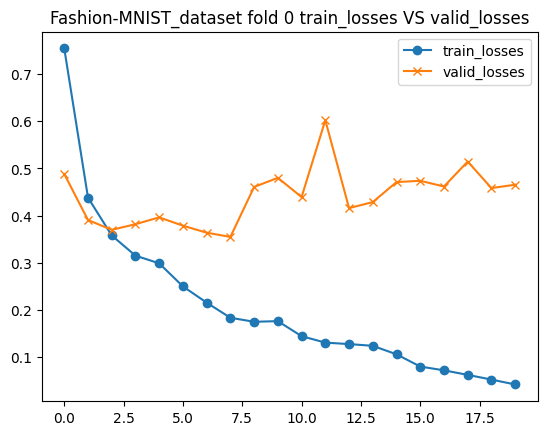

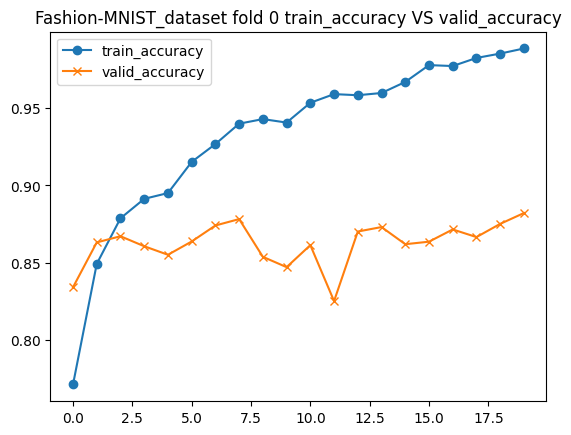

fold:1------------------------
epoch:0
train_loss:0.7475168704986572,train_accuracy:0.7726617907801417
valid_loss:0.49225878715515137,valid_accuracy:0.8336666666666667
epoch:1
train_loss:0.42760470509529114,train_accuracy:0.8567154255319149
valid_loss:0.4353426396846771,valid_accuracy:0.8505625
epoch:2
train_loss:0.34391123056411743,train_accuracy:0.883560505319149
valid_loss:0.4166328012943268,valid_accuracy:0.8487708333333334
epoch:3
train_loss:0.3014610707759857,train_accuracy:0.8939217641843971
valid_loss:0.393917441368103,valid_accuracy:0.8564375
epoch:4
train_loss:0.2739448845386505,train_accuracy:0.9045877659574468
valid_loss:0.4076961278915405,valid_accuracy:0.8573333333333333
epoch:5
train_loss:0.2521379590034485,train_accuracy:0.9141733156028369
valid_loss:0.3571365475654602,valid_accuracy:0.8735833333333334
epoch:6
train_loss:0.21143561601638794,train_accuracy:0.9275265957446809
valid_loss:0.4078844487667084,valid_accuracy:0.8688333333333333
epoch:7
train_loss:0.172993943095

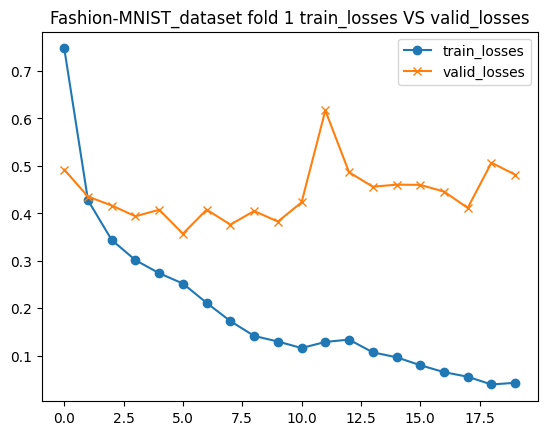

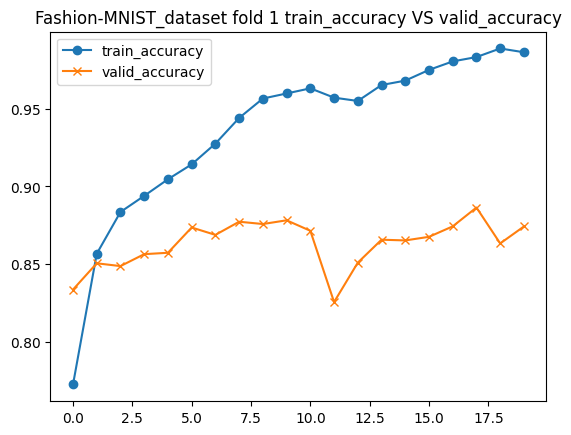

fold:2------------------------
epoch:0
train_loss:0.7690287828445435,train_accuracy:0.7624390514184397
valid_loss:0.5022903084754944,valid_accuracy:0.8235416666666666
epoch:1
train_loss:0.4493262469768524,train_accuracy:0.8482103280141844
valid_loss:0.4127163589000702,valid_accuracy:0.8587291666666667
epoch:2
train_loss:0.36208757758140564,train_accuracy:0.8768284574468085
valid_loss:0.3648698031902313,valid_accuracy:0.869875
epoch:3
train_loss:0.30330854654312134,train_accuracy:0.897052304964539
valid_loss:0.40031030774116516,valid_accuracy:0.8558541666666667
epoch:4
train_loss:0.26443764567375183,train_accuracy:0.9112367021276596
valid_loss:0.3516312539577484,valid_accuracy:0.8716666666666667
epoch:5
train_loss:0.22388100624084473,train_accuracy:0.9260859929078014
valid_loss:0.397793710231781,valid_accuracy:0.857375
epoch:6
train_loss:0.2051171511411667,train_accuracy:0.9320146276595744
valid_loss:0.3905421197414398,valid_accuracy:0.864375
epoch:7
train_loss:0.19024258852005005,train

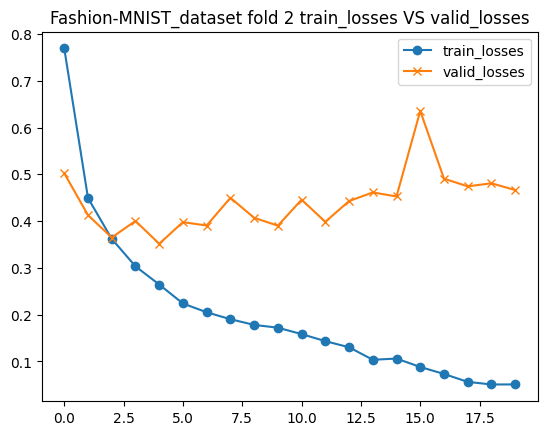

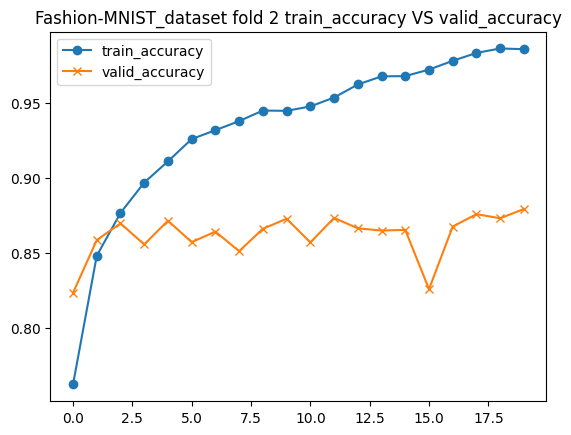

fold:3------------------------
epoch:0
train_loss:0.7538474202156067,train_accuracy:0.7673980496453902
valid_loss:0.5054253339767456,valid_accuracy:0.8244375
epoch:1
train_loss:0.4516758918762207,train_accuracy:0.8441655585106383
valid_loss:0.41430923342704773,valid_accuracy:0.8591666666666666
epoch:2
train_loss:0.3750389516353607,train_accuracy:0.8686835106382979
valid_loss:0.41251134872436523,valid_accuracy:0.8481666666666666
epoch:3
train_loss:0.3314729630947113,train_accuracy:0.8861923758865248
valid_loss:0.3628975749015808,valid_accuracy:0.8681458333333333
epoch:4
train_loss:0.2867659032344818,train_accuracy:0.9029532358156029
valid_loss:0.38032445311546326,valid_accuracy:0.8617708333333334
epoch:5
train_loss:0.2602485120296478,train_accuracy:0.9086325354609929
valid_loss:0.35994571447372437,valid_accuracy:0.8722291666666667
epoch:6
train_loss:0.2420455515384674,train_accuracy:0.9201850620567376
valid_loss:0.3659733533859253,valid_accuracy:0.8724375
epoch:7
train_loss:0.2039556503

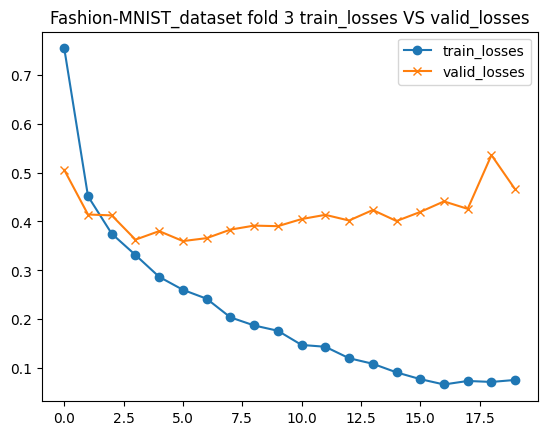

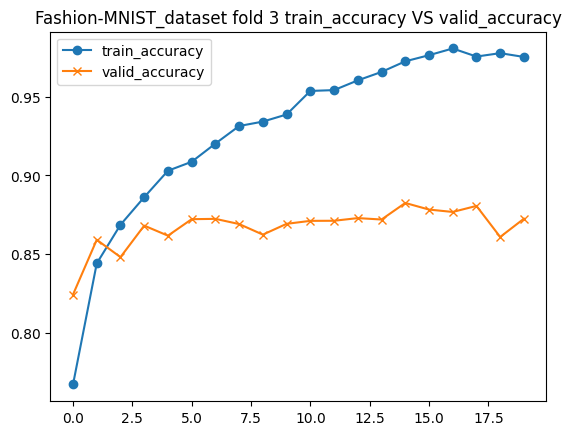

fold:4------------------------
epoch:0
train_loss:0.7560136914253235,train_accuracy:0.7712211879432624
valid_loss:0.4925558269023895,valid_accuracy:0.8283333333333334
epoch:1
train_loss:0.4483396112918854,train_accuracy:0.8465757978723404
valid_loss:0.4127885699272156,valid_accuracy:0.856375
epoch:2
train_loss:0.3641583025455475,train_accuracy:0.8758588209219859
valid_loss:0.38926294445991516,valid_accuracy:0.8636041666666666
epoch:3
train_loss:0.3157227635383606,train_accuracy:0.890126329787234
valid_loss:0.4076705276966095,valid_accuracy:0.8493541666666666
epoch:4
train_loss:0.2854378819465637,train_accuracy:0.9007092198581561
valid_loss:0.37293803691864014,valid_accuracy:0.8664791666666667
epoch:5
train_loss:0.24726669490337372,train_accuracy:0.9189660904255319
valid_loss:0.34410789608955383,valid_accuracy:0.8786666666666667
epoch:6
train_loss:0.2174762338399887,train_accuracy:0.9274434840425532
valid_loss:0.3813912272453308,valid_accuracy:0.8648541666666667
epoch:7
train_loss:0.204

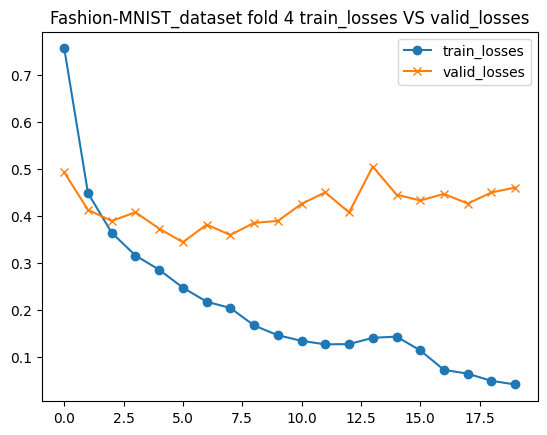

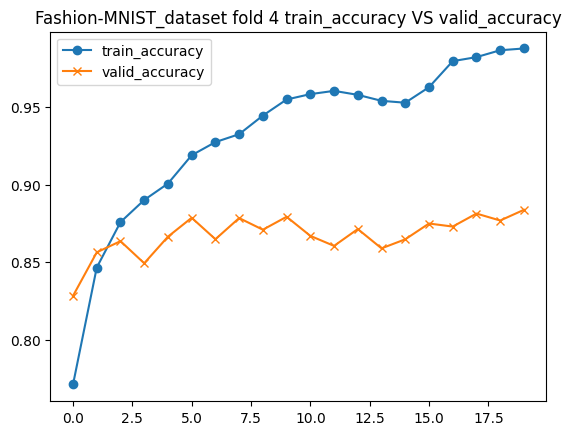

In [6]:
def cross_entropy_loss(y_pro,y_target,eps=1e-15):
    y_target=torch.eye(int(y_pro.shape[-1]))[y_target]
    y_pro=torch.clip(y_pro,eps,1-eps)
    y_target=torch.clip(y_target,eps,1-eps)
    return -torch.mean(torch.sum(y_target*torch.log(y_pro),dim=1),dim=0)
def accuracy(y_true,y_pred):
    return np.mean(y_true==y_pred)

device='cuda' if torch.cuda.is_available() else"cpu"
print(f"device:{device}")

total_idx=np.arange(len(X))
np.random.shuffle(total_idx)
for fold in range(Config.num_folds):
    print(f"fold:{fold}------------------------")
    #交叉验证每次训练数据和验证数据的划分
    train_idx=total_idx[fold*len(X)//Config.num_folds:(fold+1)*len(X)//Config.num_folds]
    valid_idx=[idx for idx in total_idx if idx not in train_idx]
    train_X,train_y=X[train_idx],y[train_idx]
    valid_X,valid_y=X[valid_idx],y[valid_idx]
    #模型设置
    model=FashionMNISTCNN().to(device)
    #优化器设置
    optimizer=optim.Adam(model.parameters(),lr=0.00025,betas=(0.5,0.999))
    train_losses=[]
    valid_losses=[]
    train_accuracys=[]
    valid_accuracys=[]
    for epoch in range(Config.num_epochs):
        print(f"epoch:{epoch}")
        #模型设置为训练状态
        model.train()
        #将梯度清空
        optimizer.zero_grad()
        train_loss=[]
        train_accuracy=[]
        for idx in range(0,len(train_X),Config.batch_size):
            train_X1=torch.Tensor(train_X[idx:idx+Config.batch_size])
            train_y1=torch.Tensor(train_y[idx:idx+Config.batch_size]).long()
            train_pro=model(train_X1)
            loss=cross_entropy_loss(train_pro,train_y1)
            train_pred=torch.argmax(train_pro,axis=1).detach().numpy()
            train_y1=train_y1.detach().numpy()
            #反向传播
            loss.backward()
            #优化器进行优化(梯度下降,降低误差)
            optimizer.step()
            train_loss.append(loss.detach().numpy())
            train_accuracy.append(accuracy(train_y1,train_pred))
        train_loss=np.mean(np.array(train_loss))
        train_accuracy=np.mean(np.array(train_accuracy))
        print(f"train_loss:{train_loss},train_accuracy:{train_accuracy}")
        #模型设置为评估模式
        model.eval()
        with torch.no_grad():
            valid_loss=[]
            valid_accuracy=[]
            for idx in range(0,len(valid_X),Config.batch_size):
                valid_X1=torch.Tensor(valid_X[idx:idx+Config.batch_size])
                valid_y1=torch.Tensor(valid_y[idx:idx+Config.batch_size]).long()
                valid_pro=model(valid_X1)
                loss=cross_entropy_loss(valid_pro,valid_y1)
                valid_pred=torch.argmax(valid_pro,axis=1).detach().numpy()
                valid_y1=valid_y1.detach().numpy()
                valid_loss.append(loss.detach().numpy())
                valid_accuracy.append(accuracy(valid_y1,valid_pred))
        valid_loss=np.mean(np.array(valid_loss))
        valid_accuracy=np.mean(np.array(valid_accuracy))
        print(f"valid_loss:{valid_loss},valid_accuracy:{valid_accuracy}")
        train_losses.append(train_loss)
        train_accuracys.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracys.append(valid_accuracy)
    torch.save(model,f"fold{fold}.pth")
    epochs=np.arange(Config.num_epochs)
    plt.title(f"Fashion-MNIST_dataset fold {fold} train_losses VS valid_losses")
    plt.plot(epochs,train_losses,marker="o",label="train_losses")
    plt.plot(epochs,valid_losses,marker="x",label="valid_losses")
    plt.legend()
    plt.show()
    plt.title(f"Fashion-MNIST_dataset fold {fold} train_accuracy VS valid_accuracy")
    plt.plot(epochs,train_accuracys,marker="o",label="train_accuracy")
    plt.plot(epochs,valid_accuracys,marker="x",label="valid_accuracy")
    plt.legend()
    plt.show()

#### 最后在测试集上查看准确率.

In [7]:
print("eval")
test_pros=np.zeros((Config.num_folds,len(test_X),Config.num_classes))
for fold in range(Config.num_folds):
    print(f"fold:{fold}")
    model=torch.load(f"fold{fold}.pth")
    model.eval()
    with torch.no_grad():
        for idx in range(0,len(test_X),Config.batch_size):
            test_X1=torch.Tensor(test_X[idx:idx+Config.batch_size])
            test_pro=model(test_X1).detach().numpy()
            test_pros[fold,idx:idx+len(test_X1)]=test_pro
test_pros=test_pros.mean(axis=0)
test_preds=np.argmax(test_pros,axis=1)
print(f"accuracy:{np.mean(test_preds==test_y)}")

eval
fold:0
fold:1
fold:2
fold:3
fold:4
accuracy:0.915
